In [1]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays
using Kinetic

In [2]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [369]:
D = read_dict("../code/shock/shock1D.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 5
nh = 12



In [370]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [453]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.fL)
end

In [454]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.01935499f0:0.07741996f0

In [456]:
residual = Array{Float32}(undef, 3)
for iter=1:1000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [457]:
#data_init = [ Float32.(maxwellian(vSpace.u, ib.primL)) |> Array, Float32.(maxwellian(vSpace.u, ib.primR)) |> Array ]
#data_para = [ [maxwellian(ks.vSpace.u, ks.ib.primL), vhs_collision_time(ks.ib.primL, ks.gas.μᵣ, ks.gas.ω)],
#              [maxwellian(ks.vSpace.u, ks.ib.primR), vhs_collision_time(ks.ib.primR, ks.gas.μᵣ, ks.gas.ω)] ];

data_init = []
data_para = []
for i=2:49
    push!(data_init, ctr[i].f[1:end])
    push!(data_para, [maxwellian(ks.vSpace.u, ctr[i].prim), vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)])
end

In [458]:
#prob = ODEProblem(bgk!, data_init[1], tSpan, data_para[1])
#data_boltz1 = solve(prob, Tsit5(), saveat=tRan) |> Array;
#prob = ODEProblem(bgk!, data_init[2], tSpan, data_para[2])
#data_boltz2 = solve(prob, Tsit5(), saveat=tRan) |> Array;
#data_boltz = [data_boltz1, data_boltz2];

data_boltz = []
for i in eachindex(data_init)
    prob = ODEProblem(bgk!, data_init[i], tSpan, data_para[i])
    push!(data_boltz, solve(prob, Tsit5(), saveat=tRan) |> Array)
end

In [459]:
dudt = FastChain( (x, p) -> x.^3,
                   FastDense(vSpace.nu, vSpace.nu*8, tanh),
                   #FastDense(vSpace.nu*16, vSpace.nu*16, tanh),
                   FastDense(vSpace.nu*8, vSpace.nu) )
n_ode = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan)

(::NeuralODE{FastChain{Tuple{var"#65#66",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float32,Float32},Tsit5,Tuple{},Base.Iterators.Pairs{Symbol,StepRangeLen{Float32,Float64,Float64},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float32,Float64,Float64}}}}}) (generic function with 4 methods)

In [460]:
function loss_n_ode(p)
    pred = n_ode(data_init[1], p) |> Array

    loss = 0.
    for i in eachindex(data_init)
        loss += sum(abs2, (n_ode(data_init[i], p) |> Array) .- data_boltz[i])
    end
    
    return loss, pred
end

loss_n_ode (generic function with 1 method)

In [ ]:
function loss_single(p, data)
    data_init, data_sol = data
    pred = n_ode(data_init, p) |> Array
    loss = sum(abs2, (n_ode(data_init, p) |> Array) .- data_sol)
    return loss, pred
end
node_series = Array{Any}(undef, 10)
for i in eachindex(node_series)
    node_series[i] = deepcopy(n_ode)
end

In [461]:
cb = function (p, l, pred; doplot=false)
    display(l)
    # plot current prediction against dataset
    if doplot
        pl = plot(tRan, data_boltz[1][vSpace.nu÷2,:], lw=2, label="Exact")
        scatter!(pl, tRan, pred[vSpace.nu÷2,:], lw=2, label="NN")
        display(plot(pl))
    end
    return false
end

#67 (generic function with 1 method)

In [462]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=100)

0.007000292491284199

loss: 0.007:   1%|▍                                        |  ETA: 0:13:12

0.003420209701289423

loss: 0.00342:   2%|▉                                        |  ETA: 0:07:05

0.0018181369232479483

loss: 0.00182:   3%|█▎                                       |  ETA: 0:05:17

0.001455072360840859

loss: 0.00146:   4%|█▋                                       |  ETA: 0:04:09

0.001678998733041226

loss: 0.00168:   5%|██                                       |  ETA: 0:03:28

0.0019815790656139143

loss: 0.00198:   6%|██▌                                      |  ETA: 0:03:01

0.0020709826476377202

loss: 0.00207:   7%|██▉                                      |  ETA: 0:02:41

0.0019026617392228218

loss: 0.0019:   8%|███▎                                     |  ETA: 0:02:26

0.0015827677361812675

loss: 0.00158:   9%|███▊                                     |  ETA: 0:02:14

0.0012495463902268966

loss: 0.00125:  10%|████▏                                    |  ETA: 0:02:04

0.0010039115700237744

loss: 0.001:  11%|████▌                                    |  ETA: 0:01:56

0.00088716952041068

loss: 0.000887:  12%|████▉                                    |  ETA: 0:01:49

0.0008898437906736945

loss: 0.00089:  13%|█████▍                                   |  ETA: 0:01:43

0.0009698663038761879

loss: 0.00097:  14%|█████▊                                   |  ETA: 0:01:38

0.0010719548145061708

loss: 0.00107:  15%|██████▏                                  |  ETA: 0:01:34

0.0011468918437458342

loss: 0.00115:  16%|██████▌                                  |  ETA: 0:01:30

0.0011660863106044417

loss: 0.00117:  17%|███████                                  |  ETA: 0:01:26

0.0011251131791141233

loss: 0.00113:  18%|███████▍                                 |  ETA: 0:01:23

0.0010382383479736745

loss: 0.00104:  19%|███████▊                                 |  ETA: 0:01:20

0.0009310233513133426

loss: 0.000931:  20%|████████▎                                |  ETA: 0:01:17

0.0008322472556301364

loss: 0.000832:  21%|████████▋                                |  ETA: 0:01:15

0.0007650853151517367

loss: 0.000765:  22%|█████████                                |  ETA: 0:01:12

0.0007397786987439758

loss: 0.00074:  23%|█████████▍                               |  ETA: 0:01:10

0.0007507217974307423

loss: 0.000751:  24%|█████████▉                               |  ETA: 0:01:08

0.0007801042584105744

loss: 0.00078:  25%|██████████▎                              |  ETA: 0:01:06

0.0008066127520578448

loss: 0.000807:  26%|██████████▋                              |  ETA: 0:01:04

0.0008144973353410023

loss: 0.000814:  27%|███████████▏                             |  ETA: 0:01:03

0.000798580494347334

loss: 0.000799:  28%|███████████▌                             |  ETA: 0:01:01

0.0007638999647952005

loss: 0.000764:  29%|███████████▉                             |  ETA: 0:00:59

0.0007215399301685466

loss: 0.000722:  30%|████████████▎                            |  ETA: 0:00:58

0.0006833122514535717

loss: 0.000683:  31%|████████████▊                            |  ETA: 0:00:56

0.0006575236066623802

loss: 0.000658:  32%|█████████████▏                           |  ETA: 0:00:55

0.0006468983527838645

loss: 0.000647:  33%|█████████████▌                           |  ETA: 0:00:54

0.000648656721352836

loss: 0.000649:  34%|██████████████                           |  ETA: 0:00:52

0.0006563544311006808

loss: 0.000656:  35%|██████████████▍                          |  ETA: 0:00:51

0.000662774922261633

loss: 0.000663:  36%|██████████████▊                          |  ETA: 0:00:50

0.0006627281176747601

loss: 0.000663:  37%|███████████████▏                         |  ETA: 0:00:49

0.0006544866201352306

loss: 0.000654:  38%|███████████████▋                         |  ETA: 0:00:48

0.0006395195381401209

loss: 0.00064:  39%|████████████████                         |  ETA: 0:00:47

0.0006212152324849285

loss: 0.000621:  40%|████████████████▍                        |  ETA: 0:00:45

0.0006034489290982492

loss: 0.000603:  41%|████████████████▊                        |  ETA: 0:00:44

0.0005893542056867318

loss: 0.000589:  42%|█████████████████▎                       |  ETA: 0:00:43

0.0005804610081554529

loss: 0.00058:  43%|█████████████████▋                       |  ETA: 0:00:42

0.0005763487924923538

loss: 0.000576:  44%|██████████████████                       |  ETA: 0:00:41

0.000574950338943836

loss: 0.000575:  45%|██████████████████▌                      |  ETA: 0:00:40

0.0005734264327088567

loss: 0.000573:  46%|██████████████████▉                      |  ETA: 0:00:39

0.0005693596649507526

loss: 0.000569:  47%|███████████████████▎                     |  ETA: 0:00:39

0.0005617815385789982

loss: 0.000562:  48%|███████████████████▋                     |  ETA: 0:00:38

0.000551462995588281

loss: 0.000551:  49%|████████████████████▏                    |  ETA: 0:00:37

0.0005403258749936413

loss: 0.00054:  50%|████████████████████▌                    |  ETA: 0:00:36

0.0005303677982624322

loss: 0.00053:  51%|████████████████████▉                    |  ETA: 0:00:35

0.0005227420121798332

loss: 0.000523:  52%|█████████████████████▍                   |  ETA: 0:00:34

0.0005174127296925235

loss: 0.000517:  53%|█████████████████████▊                   |  ETA: 0:00:33

0.0005134385320388901

loss: 0.000513:  54%|██████████████████████▏                  |  ETA: 0:00:32

0.0005095541171442619

loss: 0.00051:  55%|██████████████████████▌                  |  ETA: 0:00:32

0.0005047003830043195

loss: 0.000505:  56%|███████████████████████                  |  ETA: 0:00:31

0.0004984050551684049

loss: 0.000498:  57%|███████████████████████▍                 |  ETA: 0:00:30

0.0004909288313399429

loss: 0.000491:  58%|███████████████████████▊                 |  ETA: 0:00:29

0.00048305296891726357

loss: 0.000483:  59%|████████████████████████▎                |  ETA: 0:00:28

0.00047561438520915544

loss: 0.000476:  60%|████████████████████████▋                |  ETA: 0:00:28

0.0004691059526464869

loss: 0.000469:  61%|█████████████████████████                |  ETA: 0:00:27

0.0004635471267704361

loss: 0.000464:  62%|█████████████████████████▍               |  ETA: 0:00:26

0.00045856603105676186

loss: 0.000459:  63%|█████████████████████████▉               |  ETA: 0:00:25

0.00045360574682717925

loss: 0.000454:  64%|██████████████████████████▎              |  ETA: 0:00:25

0.00044820797361921905

loss: 0.000448:  65%|██████████████████████████▋              |  ETA: 0:00:24

0.000442221668208731

loss: 0.000442:  66%|███████████████████████████              |  ETA: 0:00:23

0.0004358159862931643

loss: 0.000436:  67%|███████████████████████████▌             |  ETA: 0:00:22

0.0004293445475127555

loss: 0.000429:  68%|███████████████████████████▉             |  ETA: 0:00:22

0.00042314556097267086

loss: 0.000423:  69%|████████████████████████████▎            |  ETA: 0:00:21

0.0004174061183732647

loss: 0.000417:  70%|████████████████████████████▊            |  ETA: 0:00:20

0.0004120933787703507

loss: 0.000412:  71%|█████████████████████████████▏           |  ETA: 0:00:19

0.0004069766573877587

loss: 0.000407:  72%|█████████████████████████████▌           |  ETA: 0:00:19

0.00040177888749326485

loss: 0.000402:  73%|█████████████████████████████▉           |  ETA: 0:00:18

0.00039632474098993953

loss: 0.000396:  74%|██████████████████████████████▍          |  ETA: 0:00:17

0.00039062164404413124

loss: 0.000391:  75%|██████████████████████████████▊          |  ETA: 0:00:17

0.00038481598735984335

loss: 0.000385:  76%|███████████████████████████████▏         |  ETA: 0:00:16

0.00037910147037223396

loss: 0.000379:  77%|███████████████████████████████▋         |  ETA: 0:00:15

0.00037360535978336884

loss: 0.000374:  78%|████████████████████████████████         |  ETA: 0:00:15

0.0003683418270554739

loss: 0.000368:  79%|████████████████████████████████▍        |  ETA: 0:00:14

0.00036322007716194094

loss: 0.000363:  80%|████████████████████████████████▊        |  ETA: 0:00:13

0.00035811082290138074

loss: 0.000358:  81%|█████████████████████████████████▎       |  ETA: 0:00:12

0.0003529210933379545

loss: 0.000353:  82%|█████████████████████████████████▋       |  ETA: 0:00:12

0.00034763857033226486

loss: 0.000348:  83%|██████████████████████████████████       |  ETA: 0:00:11

0.00034232704854275653

loss: 0.000342:  84%|██████████████████████████████████▌      |  ETA: 0:00:10

0.0003370743288826361

loss: 0.000337:  85%|██████████████████████████████████▉      |  ETA: 0:00:10

0.0003319387380997796

loss: 0.000332:  86%|███████████████████████████████████▎     |  ETA: 0:00:09

0.00032692623784669195

loss: 0.000327:  87%|███████████████████████████████████▋     |  ETA: 0:00:08

0.00032199529158560836

loss: 0.000322:  88%|████████████████████████████████████▏    |  ETA: 0:00:08

0.000317094182122446

loss: 0.000317:  89%|████████████████████████████████████▌    |  ETA: 0:00:07

0.0003121827136283173

loss: 0.000312:  90%|████████████████████████████████████▉    |  ETA: 0:00:06

0.00030725650341878463

loss: 0.000307:  91%|█████████████████████████████████████▎   |  ETA: 0:00:06

0.0003023398441825975

loss: 0.000302:  92%|█████████████████████████████████████▊   |  ETA: 0:00:05

0.0002974763486633947

loss: 0.000297:  93%|██████████████████████████████████████▏  |  ETA: 0:00:04

0.0002926975397201659

loss: 0.000293:  94%|██████████████████████████████████████▌  |  ETA: 0:00:04

0.00028800540417250886

loss: 0.000288:  95%|███████████████████████████████████████  |  ETA: 0:00:03

0.000283375848198375

loss: 0.000283:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03

0.00027877640934548253

loss: 0.000279:  97%|███████████████████████████████████████▊ |  ETA: 0:00:02

0.0002741920887388005

loss: 0.000274:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

0.00026962858453316585

loss: 0.00027:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

0.00026510355610298575

loss: 0.000265: 100%|█████████████████████████████████████████| Time: 0:01:03


0.00026510355610298575

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-5.54e-02, -5.19e-02, -5.02e-02,  ...]
    Minimum:   2.651036e-04

 * Found with
    Algorithm:     ADAM
    Initial Point: [-5.54e-02, -5.19e-02, -5.02e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   64  (vs limit Inf)
    Iterations:    100
    f(x) calls:    100
    ∇f(x) calls:   100


In [420]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, ADAM(), cb=cb, maxiters=100)

8.159586457168189e-6

loss: 8.16e-06:   1%|▍                                        |  ETA: 0:00:40

0.00022265419920586282

loss: 0.000223:   2%|▉                                        |  ETA: 0:00:31

2.7617306727734103e-5

loss: 2.76e-05:   3%|█▎                                       |  ETA: 0:00:27

4.6422990862993174e-5

loss: 4.64e-05:   4%|█▋                                       |  ETA: 0:00:25

0.000103631985894026

loss: 0.000104:   5%|██                                       |  ETA: 0:00:24

8.078896962615545e-5

loss: 8.08e-05:   6%|██▌                                      |  ETA: 0:00:23

2.8717137638523127e-5

loss: 2.87e-05:   7%|██▉                                      |  ETA: 0:00:23

6.9255724781669414e-6

loss: 6.93e-06:   8%|███▎                                     |  ETA: 0:00:22

2.2673118905913725e-5

loss: 2.27e-05:   9%|███▊                                     |  ETA: 0:00:21

4.4305523715593154e-5

loss: 4.43e-05:  10%|████▏                                    |  ETA: 0:00:21

4.573581941258453e-5

loss: 4.57e-05:  11%|████▌                                    |  ETA: 0:00:21

2.888345898099942e-5

loss: 2.89e-05:  12%|████▉                                    |  ETA: 0:00:20

1.0300991959866224e-5

loss: 1.03e-05:  13%|█████▍                                   |  ETA: 0:00:20

3.2952559223531352e-6

loss: 3.3e-06:  14%|█████▊                                   |  ETA: 0:00:20

9.504834110884985e-6

loss: 9.5e-06:  15%|██████▏                                  |  ETA: 0:00:19

1.9857898791997286e-5

loss: 1.99e-05:  16%|██████▌                                  |  ETA: 0:00:19

2.368423258758412e-5

loss: 2.37e-05:  17%|███████                                  |  ETA: 0:00:19

1.805113845421147e-5

loss: 1.81e-05:  18%|███████▍                                 |  ETA: 0:00:18

8.15370191276088e-6

loss: 8.15e-06:  19%|███████▊                                 |  ETA: 0:00:18

1.4735931230802635e-6

loss: 1.47e-06:  20%|████████▎                                |  ETA: 0:00:18

1.9766600445336735e-6

loss: 1.98e-06:  21%|████████▋                                |  ETA: 0:00:18

7.494633507576509e-6

loss: 7.49e-06:  22%|█████████                                |  ETA: 0:00:17

1.2021222573821433e-5

loss: 1.2e-05:  23%|█████████▍                               |  ETA: 0:00:17

1.1383043840851315e-5

loss: 1.14e-05:  24%|█████████▉                               |  ETA: 0:00:17

6.559205388612099e-6

loss: 6.56e-06:  25%|██████████▎                              |  ETA: 0:00:17

1.7670463066110642e-6

loss: 1.77e-06:  26%|██████████▋                              |  ETA: 0:00:16

3.6885466592195826e-7

loss: 3.69e-07:  27%|███████████▏                             |  ETA: 0:00:16

2.401150510422667e-6

loss: 2.4e-06:  28%|███████████▌                             |  ETA: 0:00:16

5.211444261021825e-6

loss: 5.21e-06:  29%|███████████▉                             |  ETA: 0:00:16

6.1453420130419545e-6

loss: 6.15e-06:  30%|████████████▎                            |  ETA: 0:00:15

4.6415191263804445e-6

loss: 4.64e-06:  31%|████████████▊                            |  ETA: 0:00:15

2.13867582488092e-6

loss: 2.14e-06:  32%|█████████████▏                           |  ETA: 0:00:15

5.0416293362332e-7

loss: 5.04e-07:  33%|█████████████▌                           |  ETA: 0:00:15

6.061892356967746e-7

loss: 6.06e-07:  34%|██████████████                           |  ETA: 0:00:15

1.9033160896242407e-6

loss: 1.9e-06:  35%|██████████████▍                          |  ETA: 0:00:14

3.029362787287937e-6

loss: 3.03e-06:  36%|██████████████▊                          |  ETA: 0:00:14

2.944134237736762e-6

loss: 2.94e-06:  37%|███████████████▏                         |  ETA: 0:00:14

1.7718572706826308e-6

loss: 1.77e-06:  38%|███████████████▋                         |  ETA: 0:00:14

5.344587954425606e-7

loss: 5.34e-07:  39%|████████████████                         |  ETA: 0:00:13

1.4463673458919857e-7

loss: 1.45e-07:  40%|████████████████▍                        |  ETA: 0:00:13

6.893057893364585e-7

loss: 6.89e-07:  41%|████████████████▊                        |  ETA: 0:00:13

1.4756259076875722e-6

loss: 1.48e-06:  42%|█████████████████▎                       |  ETA: 0:00:13

1.6977905801240922e-6

loss: 1.7e-06:  43%|█████████████████▋                       |  ETA: 0:00:13

1.168338251034129e-6

loss: 1.17e-06:  44%|██████████████████                       |  ETA: 0:00:12

4.057352089859023e-7

loss: 4.06e-07:  45%|██████████████████▌                      |  ETA: 0:00:12

5.799985580701161e-8

loss: 5.8e-08:  46%|██████████████████▉                      |  ETA: 0:00:12

3.071418213096422e-7

loss: 3.07e-07:  47%|███████████████████▎                     |  ETA: 0:00:12

7.637347891886748e-7

loss: 7.64e-07:  48%|███████████████████▋                     |  ETA: 0:00:11

9.194536048084956e-7

loss: 9.19e-07:  49%|████████████████████▏                    |  ETA: 0:00:11

6.60302255539591e-7

loss: 6.6e-07:  50%|████████████████████▌                    |  ETA: 0:00:11

2.689578444403651e-7

loss: 2.69e-07:  51%|████████████████████▉                    |  ETA: 0:00:11

6.993521273201964e-8

loss: 6.99e-08:  52%|█████████████████████▍                   |  ETA: 0:00:11

1.6574910244315788e-7

loss: 1.66e-07:  53%|█████████████████████▊                   |  ETA: 0:00:10

3.9428890374892944e-7

loss: 3.94e-07:  54%|██████████████████████▏                  |  ETA: 0:00:10

4.992871680542521e-7

loss: 4.99e-07:  55%|██████████████████████▌                  |  ETA: 0:00:10

3.794842484694527e-7

loss: 3.79e-07:  56%|███████████████████████                  |  ETA: 0:00:10

1.59195971072279e-7

loss: 1.59e-07:  57%|███████████████████████▍                 |  ETA: 0:00:09

3.7741489267162365e-8

loss: 3.77e-08:  58%|███████████████████████▊                 |  ETA: 0:00:09

9.82068821819837e-8

loss: 9.82e-08:  59%|████████████████████████▎                |  ETA: 0:00:09

2.3934113535517554e-7

loss: 2.39e-07:  60%|████████████████████████▋                |  ETA: 0:00:09

2.9145264512919766e-7

loss: 2.91e-07:  61%|█████████████████████████                |  ETA: 0:00:09

1.9992951383329682e-7

loss: 2e-07:  62%|█████████████████████████▍               |  ETA: 0:00:08

6.757033332860374e-8

loss: 6.76e-08:  63%|█████████████████████████▉               |  ETA: 0:00:08

2.5235755984898134e-8

loss: 2.52e-08:  64%|██████████████████████████▎              |  ETA: 0:00:08

8.813162333254354e-8

loss: 8.81e-08:  65%|██████████████████████████▋              |  ETA: 0:00:08

1.587952782600155e-7

loss: 1.59e-07:  66%|███████████████████████████              |  ETA: 0:00:07

1.5661563157465253e-7

loss: 1.57e-07:  67%|███████████████████████████▌             |  ETA: 0:00:07

9.352173879761949e-8

loss: 9.35e-08:  68%|███████████████████████████▉             |  ETA: 0:00:07

3.57466142242302e-8

loss: 3.57e-08:  69%|████████████████████████████▎            |  ETA: 0:00:07

3.1330938177198675e-8

loss: 3.13e-08:  70%|████████████████████████████▊            |  ETA: 0:00:07

6.981594857791151e-8

loss: 6.98e-08:  71%|█████████████████████████████▏           |  ETA: 0:00:06

1.0060450339466342e-7

loss: 1.01e-07:  72%|█████████████████████████████▌           |  ETA: 0:00:06

8.735240930590749e-8

loss: 8.74e-08:  73%|█████████████████████████████▉           |  ETA: 0:00:06

4.524030927655076e-8

loss: 4.52e-08:  74%|██████████████████████████████▍          |  ETA: 0:00:06

1.9932416814305576e-8

loss: 1.99e-08:  75%|██████████████████████████████▊          |  ETA: 0:00:06

3.26800512207015e-8

loss: 3.27e-08:  76%|███████████████████████████████▏         |  ETA: 0:00:05

5.970330918536604e-8

loss: 5.97e-08:  77%|███████████████████████████████▋         |  ETA: 0:00:05

6.532243013168682e-8

loss: 6.53e-08:  78%|████████████████████████████████         |  ETA: 0:00:05

4.383995666490392e-8

loss: 4.38e-08:  79%|████████████████████████████████▍        |  ETA: 0:00:05

2.1760823004646213e-8

loss: 2.18e-08:  80%|████████████████████████████████▊        |  ETA: 0:00:04

2.1590471743770934e-8

loss: 2.16e-08:  81%|█████████████████████████████████▎       |  ETA: 0:00:04

3.6254709234739835e-8

loss: 3.63e-08:  82%|█████████████████████████████████▋       |  ETA: 0:00:04

4.476956627641471e-8

loss: 4.48e-08:  83%|██████████████████████████████████       |  ETA: 0:00:04

3.7782202477743e-8

loss: 3.78e-08:  84%|██████████████████████████████████▌      |  ETA: 0:00:04

2.4194050762815777e-8

loss: 2.42e-08:  85%|██████████████████████████████████▉      |  ETA: 0:00:03

1.860351406257621e-8

loss: 1.86e-08:  86%|███████████████████████████████████▎     |  ETA: 0:00:03

2.4323644653989618e-8

loss: 2.43e-08:  87%|███████████████████████████████████▋     |  ETA: 0:00:03

3.21741489006655e-8

loss: 3.22e-08:  88%|████████████████████████████████████▏    |  ETA: 0:00:03

3.182665975209886e-8

loss: 3.18e-08:  89%|████████████████████████████████████▌    |  ETA: 0:00:02

2.3389666425899236e-8

loss: 2.34e-08:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

1.7438478695785964e-8

loss: 1.74e-08:  91%|█████████████████████████████████████▎   |  ETA: 0:00:02

2.0021011390425336e-8

loss: 2e-08:  92%|█████████████████████████████████████▊   |  ETA: 0:00:02

2.551990752053257e-8

loss: 2.55e-08:  93%|██████████████████████████████████████▏  |  ETA: 0:00:02

2.6137833342154693e-8

loss: 2.61e-08:  94%|██████████████████████████████████████▌  |  ETA: 0:00:01

2.1501298880233222e-8

loss: 2.15e-08:  95%|███████████████████████████████████████  |  ETA: 0:00:01

1.7680794248825515e-8

loss: 1.77e-08:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

1.8419037649264336e-8

loss: 1.84e-08:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

2.1429395646865856e-8

loss: 2.14e-08:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

2.2406912131289758e-8

loss: 2.24e-08:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

2.0190548413734355e-8

loss: 2.02e-08: 100%|█████████████████████████████████████████| Time: 0:00:21


1.7438478695785964e-8

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-1.01e-01, 1.42e-03, -7.21e-02,  ...]
    Minimum:   2.019055e-08

 * Found with
    Algorithm:     ADAM
    Initial Point: [-1.01e-01, 1.42e-03, -7.21e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    100
    f(x) calls:    100
    ∇f(x) calls:   100


In [421]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, LBFGS(), cb=cb, maxiters=100)

1.761360731919459e-8

1.694692714979129e-8

1.6927998942699307e-8

1.6927859794457767e-8

1.6927629066694483e-8

1.692701491126658e-8

1.692605555714266e-8

1.6925962050343135e-8

1.6925357936362073e-8

1.6925255613697843e-8

1.6925255252007998e-8

 * Status: success

 * Candidate solution
    Minimizer: [-1.01e-01, 1.42e-03, -7.21e-02,  ...]
    Minimum:   1.692526e-08

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [-1.01e-01, 1.42e-03, -7.21e-02,  ...]

 * Convergence measures
    |x - x'|               = 2.33e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 9.72e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   28  (vs limit Inf)
    Iterations:    10
    f(x) calls:    118
    ∇f(x) calls:   118


In [422]:
function step_train!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    data = solve(ODEProblem(bgk!, f[1:end], tSpan, [M, τ]), Tsit5(), saveat=tRan) |> Array;
    pred = n_ode(f[1:end], p) |> Array
    loss = sum(abs2, pred .- data)

    if loss <= 1.e-6
        ftemp = n_ode(f[1:end], p).u[end]
    	for i in eachindex(u)
    		f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    	end
    else
        for i in eachindex(u)
    		f[i] += (ffL[i] - ffR[i]) / dx + (M[i] - f[i]) / τ * tRan[end]
    	end
        
        #push!(datainit, f[1:end])
        #push!(dataset, data)
    end
end

function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    prim_old = deepcopy(prim)
    
    #--- update W^{n+1} ---#
	@. w = w_old + (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)
    
    M = maxwellian(u, prim_old)
	τ = vhs_collision_time(prim_old, μ, ω)
    
    #ftemp = f .+ (M .- f) / τ * tRan[end]
    prob = ODEProblem(bgk!, f[1:end], (0, tRan[end]), (M, τ))
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end

end

step_node! (generic function with 1 method)

In [451]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))
for iter = 1:20

    Kinetic.evolve!(ks, ctr, face, dt)
#=
    for i in 2:10
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
=#
    for i in 2:35
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_bgk!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
    
    for i in 36:49
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end

end

In [223]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))
for iter = 1:100
    Kinetic.evolve!(ks, ctr, face, dt)
    
    for i in 2:49
        step_bgk!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
end

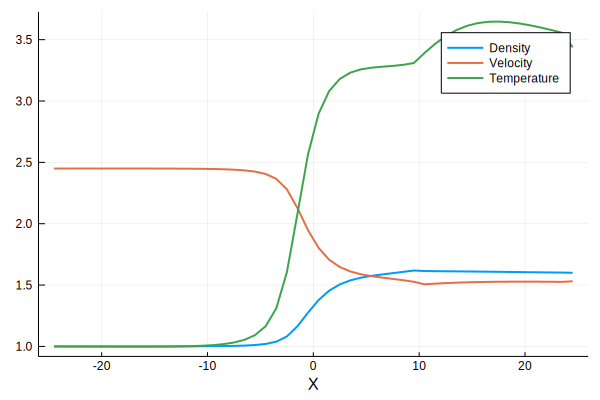

In [452]:
plot_line(ks, ctr)

In [ ]:
plot(ks.vSpace.u[20:25], (n_ode(ctr[25].f[1:end], res.minimizer) |> Array)[:,1][20:25])
plot!(ks.vSpace.u[20:25], (n_ode(ctr[25].f[1:end], res.minimizer) |> Array)[:,2][20:25])   

In [ ]:
plot(ks.vSpace.u[20:25], data_boltz[24][20:25,1])
plot!(ks.vSpace.u[20:25], data_boltz[24][20:25,2])

In [238]:
data_boltz[1]

36×2 Array{Float32,2}:
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 0.0          0.0
 6.0f-45      6.0f-45
 3.118f-40    3.118f-40
 8.86555f-36  8.86555f-36
 1.35973f-31  1.35973f-31
 1.12491f-27  1.12491f-27
 5.01992f-24  5.01992f-24
 1.20836f-20  1.20836f-20
 ⋮            
 0.561946     0.561946
 0.442704     0.442704
 0.188126     0.188126
 0.0431223    0.0431223
 0.00533177   0.00533177
 0.000355597  0.000355597
 1.27927f-5   1.27927f-5
 2.48246f-7   2.48246f-7
 2.59848f-9   2.59848f-9
 1.46715f-11  1.46715f-11
 4.46834f-14  4.46834f-14
 7.34065f-17  7.34065f-17